# **Setup**

In [1]:
#@title Available Memory - On Google Colab
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Running setup.py bdist_wheel for gputil ... - done
  Stored in directory: /root/.cache/pip/wheels/17/0f/04/b79c006972335e35472c0b835ed52bfc0815258d409f560108
Successfully built gputil
  Running setup.py bdist_wheel for humanize ... - done
  Stored in directory: /root/.cache/pip/wheels/69/86/6c/f8b8593bc273ec4b0c653d3827f7482bb2001a2781a73b7f44
Successfully built humanize
Gen RAM Free: 13.0 GB  | Proc size: 137.8 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [2]:
#@title Mount Google Drive
from google.colab import drive, files
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
#@title Imports { vertical-output: true }
import os
import random
import unicodedata
import re
import numpy as np
import time
import datetime
import dill
import tensorflow as tf
from ast import literal_eval

from __future__ import absolute_import, division, print_function

#configi = tf.ConfigProto()
#configi.gpu_options.allow_growth = True
tf.enable_eager_execution()

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


print('Tensorflow Version:', tf.__version__)

Tensorflow Version: 1.12.0-rc2


# **Functions**

In [0]:
#@title Cornell Movie Dialog Processor { display-mode: "code" }
DELIM = ' +++$+++ '


class CornellMovieCorpusProcessor:

    def __init__(self, lines, conversations):
        self.movie_lines_filepath = lines
        self.movie_conversations = conversations
        
    def unicode_to_ascii(s):
      return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
    
    def preprocess_sentence(w):
      w = CornellMovieCorpusProcessor.unicode_to_ascii(w.lower().strip())

      w = re.sub(r"([?.!,'])", r" \1 ", w)
      w = re.sub(r'[" "]+', " ", w)

      w = re.sub(r"[^a-zA-Z?.!,']+", " ", w)

      w = w.rstrip().strip()

      w = '<start> ' + w + ' <end>'
      return w

    def get_id2line(self):
        """
        1. Read from 'movie-lines.txt'
        2. Create a dictionary with ( key = line_id, value = text )
        :return: (dict) {line-id: text, ...}
        """
        id2line = {}
        id_index = 0
        text_index = 4
        with open(self.movie_lines_filepath, 'r', encoding='iso-8859-1') as f:
            for line in f:
                items = line.split(DELIM)
                #print(items)
                if len(items) == 5:
                    line_id = items[id_index]
                    #print(line_id, id_index)
                    dialog_text = items[text_index].strip()
                    dialog_text = CornellMovieCorpusProcessor.preprocess_sentence(dialog_text)
                    #print(dialog_text)
                    id2line[line_id] = dialog_text
                    #print(id2line[line_id])
        return id2line

    def get_conversations(self):
        """
        1. Read from 'movie_conversations.txt'
        2. Create a list of [list of line_id's]
        :return: [list of line_id's]
        """
        conversation_ids_index = -1
        conversations = []
        with open(self.movie_conversations, 'r', encoding='iso-8859-1') as f:
            for line in f:
                items = line.split(DELIM)
                conversation_ids_field = items[conversation_ids_index]
                #print(conversation_ids_field)
                conversation_ids = literal_eval(conversation_ids_field)  # evaluate as a python list
                conversations.append(conversation_ids)
                
        return conversations

    def get_question_answer_set(self, id2line, conversations):
        """
        Want to collect questions and answers
        (this current method is iffy... not sure how this accurately defines questions/answers...)
        :param conversations: (list) Collection line ids consisting of a single conversation
        :param id2line: (dict) mapping of line-ids to actual line text
        :return: (list) questions, (list) answers
        """
        questions = []
        answers = []

        # This uses a simple method in an attempt to gather question/answers
        for conversation in conversations:
            if len(conversation) % 2 != 0:
                conversation = conversation[:-1]  # remove last item , as conversations assumed to be in Q&A (even) format

            for idx, line_id in enumerate(conversation):
                #print(idx, line_id)
                if idx % 2 == 0:
                    questions.append(id2line[line_id])
                else:
                    answers.append(id2line[line_id])

        return questions, answers
      
    def read_glove_vecs(glove_file):
      with open(glove_file, 'r') as f:
          #words = set()
          word_to_vec_map = {}
          for line in f:
              line = line.strip().split()
              curr_word = line[0]
              #words.add(curr_word)
              word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)

      return word_to_vec_map

    def reduce_lengthy_sentences(self, questions, answers, tryy):
      new_q = []
      new_a = []
      new_q2 = []
      new_a2 = []
      
      count = 0
      total_count = 0
      
      for q, a in zip(questions, answers):
        total_count += 1
        if len(q) > tryy:
          count += 1
        else:
          new_q.append(q)
          new_a.append(a)
      print(100 - (count/total_count*100), '% or', total_count-count, 'of question sentences have lengths less than', tryy)
      print('questions with length less than', tryy, 'and their corresponding answers are copied over to a new list')
      print()

      kount = 0
      total_kount = 0
      
      for q, a in zip(new_q, new_a):
        total_kount += 1
        if len(a) > tryy:
          kount += 1
        else:
          new_q2.append(q)
          new_a2.append(a)
      print(100 - (kount/total_kount*100), '% or', total_kount-kount, 'of answer sentences have lengths less than', tryy)
      print('answers with length less than', tryy, 'and their corresponding questions are copied over to a new list')

      return new_q2, new_a2
    
    def max_length(tensor):
      return max(len(t) for t in tensor)

    def load_dataset(self, q, a, glove_file): #

      # index language using the class defined above    
      inp_lang = LanguageIndex(q)
      targ_lang = LanguageIndex(a)

      # Vectorize the input and target languages

      # Q sentences
      input_tensor = [[inp_lang.word2idx[s] for s in q.split(' ')] for q in q]

      # A sentences
      target_tensor = [[targ_lang.word2idx[s] for s in a.split(' ')] for a in a]

      # Calculate max_length of input and output tensor
      # Here, we'll set those to the longest sentence in the dataset
      max_length_inp, max_length_tar = CornellMovieCorpusProcessor.max_length(input_tensor), CornellMovieCorpusProcessor.max_length(target_tensor)

      # Padding the input and output tensor to the maximum length
      input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                   maxlen=max_length_inp,
                                                                   padding='post')

      target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
                                                                    maxlen=max_length_tar, 
                                                                    padding='post')

      em_word_to_vec_map = CornellMovieCorpusProcessor.read_glove_vecs(glove_file)

      return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar, em_word_to_vec_map
      
# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for each language,
class LanguageIndex():
  def __init__(self, lang):
      self.lang = lang
      self.word2idx = {}
      self.idx2word = {}
      self.vocab = set()
      self.create_index()

  def create_index(self):
      for phrase in self.lang:
          self.vocab.update(phrase.split(' '))

      self.vocab = sorted(self.vocab)

      self.word2idx['<pad>'] = 0
      for index, word in enumerate(self.vocab):
          self.word2idx[word] = index + 1

      for word, index in self.word2idx.items():
          self.idx2word[index] = word

# **Pre-processing**

In [5]:
#@title Get Question and Answer Conversations
processor = CornellMovieCorpusProcessor('/content/gdrive/My Drive/Colab Notebooks/movie_lines.txt', 
                                        '/content/gdrive/My Drive/Colab Notebooks/movie_conversations.txt')
MAX_N_WORD = 180
id2lines = processor.get_id2line()
conversations = processor.get_conversations()
questions, answers = processor.get_question_answer_set(id2lines, conversations)
questions, answers = processor.reduce_lengthy_sentences(questions, answers, MAX_N_WORD) # remove sentences more than n amount of words, and balences the Q&A
print()
# example Q&As
print('EXAMPLE Q&A')
for i in range(0, 10000, 2000):
  print('Q', i, ':', questions[i])
  print('A', i, ':', answers[i])

94.3801353748145 % or 130372 of question sentences have lengths less than 180
questions with length less than 180 and their corresponding answers are copied over to a new list

94.96977878685607 % or 123814 of answer sentences have lengths less than 180
answers with length less than 180 and their corresponding questions are copied over to a new list

EXAMPLE Q&A
Q 0 : <start> can we make this quick ? roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad . again . <end>
A 0 : <start> well , i thought we ' d start with pronunciation , if that ' s okay with you . <end>
Q 2000 : <start> you got what you wanted . you going to release us now ? <end>
A 2000 : <start> you ' re very valuable . and our nation needs so many things . <end>
Q 4000 : <start> why are there copies of the style section all over the place ? do you have a dog ? a chow or something ? <end>
A 4000 : <start> no , owen . <end>
Q 6000 : <start> she ' s alive ! ! she is not dead ? <

In [0]:
#@title Load Dataset
glove_file = '/content/gdrive/My Drive/Colab Notebooks/glove.6B.50d.txt'       # LOCATION OF GLOVE FILE
input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_targ, em_word_to_vec_map = processor.load_dataset(questions, answers, glove_file)
input_tensor_train, target_tensor_train = input_tensor, target_tensor # because validation data from split was not used

In [7]:
#@title Visualise Input Data
print('Raw Input Example: ', inp_lang.idx2word[80])  # taken from word vocab dict
print('Raw Target Example:', targ_lang.idx2word[80]) # taken from word vocab dict
print('Vectorised Version - Format: (num_of_examples, max_sentence_len)')
print('                Input (sp): ', input_tensor.shape)
print('               Target (en): ', target_tensor.shape)
print('Raw Input Example Vectorised: \n', input_tensor[80])
print('Raw Target Example Vectorised: \n', target_tensor[80])

#print(inp_lang.word2idx) #vocab

Raw Input Example:  aboukir
Raw Target Example: abrams
Vectorised Version - Format: (num_of_examples, max_sentence_len)
                Input (sp):  (123814, 65)
               Target (en):  (123814, 59)
Raw Input Example Vectorised: 
 [    7 11908     3 22618 18083     9 12550 22307     5 28924 26459 13691
     5     6     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0]
Raw Target Example Vectorised: 
 [    7 28775     3 20594 17344 10559 27003 28785 23273 10553     5  8197
 17594 24558     5     6     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0

In [0]:
#@title Split Data to Train & Validation Sets
# Creating training and validation sets using an 80-20 split
#input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
#print('Number of Q&A Examples for (Train Set, Validation Set)')
#len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

# **Hyperparameters**

In [0]:
#@title Adjustable Parameters
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 48
N_BATCH = BUFFER_SIZE//BATCH_SIZE # number of mini batches
use_PWE = False # if True, embedding_dim would be based on dimension of pre-trained word embedding
embedding_dim = 256
enc_units = 512
dec_units = 1024
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)


dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE, seed=1) # use alternative from (from_tensor_slices) if data is > 1 GB, see documentation
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

# **Model**

In [0]:
#@title Embedding
def pretrained_embedding_matrix(word_to_vec_map, word_to_index): # refer to base in google drive

    embedding_matrix = np.zeros((vocab_inp_size, embedding_dim))
    
    for word, i in word_to_index.items():
      embedding_vector = word_to_vec_map.get(word)
      if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

In [0]:
#@title LSTM { display-mode: "code" }
def lstm(units):
    if tf.test.is_gpu_available():
        print('gpu avaliable')
        #return tf.keras.layers.LSTM(units, return_sequences=True, return_state=True, recurrent_activation='sigmoid', recurrent_initializer='glorot_uniform')
        return tf.keras.layers.CuDNNLSTM(units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
    else:
        print('no gpu available')
        return tf.keras.layers.LSTM(units, return_sequences=True, return_state=True, recurrent_activation='sigmoid', recurrent_initializer='glorot_uniform')

In [0]:
#@title GRU
def gru(units):
    if tf.test.is_gpu_available():
        print('gpu avaliable')
        #return tf.keras.layers.GRU(units, return_sequences=True, return_state=True, recurrent_activation='sigmoid', recurrent_initializer='glorot_uniform')
        return tf.keras.layers.CuDNNGRU(units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
    else:
        print('no gpu available')
        return tf.keras.layers.GRU(units, return_sequences=True, return_state=True, recurrent_activation='sigmoid', recurrent_initializer='glorot_uniform')

In [0]:
#@title Encoder
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        if use_PWE:
          self.embedding = tf.keras.layers.Embedding(vocab_size, 
                                                     embedding_dim, 
                                                     weights=[pretrained_embedding_matrix(em_word_to_vec_map, inp_lang.word2idx)], 
                                                     trainable=False)
        else:
          self.embedding = tf.keras.layers.Embedding(vocab_size, 
                                                     embedding_dim)
        self.gru = gru(self.enc_units)
        self.bidirectionalgru = tf.keras.layers.Bidirectional(self.gru)
        self.lstm = lstm(self.enc_units)
        self.bidirectionallstm = tf.keras.layers.Bidirectional(self.lstm)
        
    def call(self, x):  # TODO: can delete hidden? (it was initial_state)
        x = self.embedding(x)
        output, hf, _cf, hb, _cb = self.bidirectionallstm(x)
        h_concat = tf.keras.layers.concatenate([hf, hb], axis=-1)  # place this in init ???
        #print('output shape: ', output.shape)
        #print('hf shape: ', hf.shape)
        #print('h_concat shape: ', h_concat.shape)
        return output, h_concat
      
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [0]:
#@title Decoder
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        if use_PWE:
          self.embedding = tf.keras.layers.Embedding(vocab_size, 
                                                     embedding_dim, 
                                                     weights=[pretrained_embedding_matrix(em_word_to_vec_map, inp_lang.word2idx)], 
                                                     trainable=False)
        else:
          self.embedding = tf.keras.layers.Embedding(vocab_size, 
                                                     embedding_dim)
        self.gru = gru(self.dec_units)
        self.lstm = lstm(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        #print('hidden shape: ', hidden.shape)                               # (64, 1024)
        #print('hidden_with_time_axis shape: ', hidden_with_time_axis.shape) # (64, 1, 1024)
        
        # score shape == (batch_size, max_length, hidden_size)
        score = tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis)) # (64, 16, 2048), (64, 1024), (64, 2048)
        #print('socre shape: ', score.shape)
        # attention_weights shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the GRU   , changed to lstm
        output, h, _c = self.lstm(x) # 
        
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size * 1, vocab)
        x = self.fc(output)
        
        return x, h, attention_weights
      
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [15]:
#@title Create Enc & Dec Instance
encoder = Encoder(vocab_inp_size, embedding_dim, enc_units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, dec_units, BATCH_SIZE)

gpu avaliable
gpu avaliable
gpu avaliable
gpu avaliable


In [0]:
#@title Optimiser & Loss Function
optimizer = tf.train.AdamOptimizer()

def loss_function(real, pred):
    mask = 1 - np.equal(real, 0) # returns 0 - True, 1 - False
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask # if wrong pred, keep/record loss
    return tf.reduce_mean(loss_) # get mean

In [0]:
#@title Checkpoint
checkpoint_dir = '/content/gdrive/My Drive/Colab Notebooks/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

# **Post-processing**

In [19]:
'''#@title
TOTAL_EPOCHS = 10
NEW = True
if NEW:
    
  EPOCHS = TOTAL_EPOCHS
else:
  with open('/content/gdrive/My Drive/Colab Notebooks/restore_previous_epoch.txt', 'rb') as f:
      for epoch in f:
        EPOCHS = TOTAL_EPOCHS - int(epoch)
  checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

  print('Number of epochs left', EPOCHS)'''

"#@title\nTOTAL_EPOCHS = 10\nNEW = True\nif NEW:\n    \n  EPOCHS = TOTAL_EPOCHS\nelse:\n  with open('/content/gdrive/My Drive/Colab Notebooks/restore_previous_epoch.txt', 'rb') as f:\n      for epoch in f:\n        EPOCHS = TOTAL_EPOCHS - int(epoch)\n  checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))\n\n  print('Number of epochs left', EPOCHS)"

In [0]:
#@title Train
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    
    #hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        
        with tf.GradientTape() as tape: # Selecting which Gradient Taping to use: https://stackoverflow.com/questions/50098971/whats-the-difference-between-gradienttape-implicit-gradients
            enc_output, enc_hidden = encoder(inp) #, hidden
            
            dec_hidden = enc_hidden
            
            dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)       
            
            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                
                loss += loss_function(targ[:, t], predictions)
                
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)
        
        batch_loss = (loss / int(targ.shape[1])) # average batch loss
        
        total_loss += batch_loss
        
        variables = encoder.variables + decoder.variables # get variables of each model (variables is a property of tf.keras.models.Model)
        
        gradients = tape.gradient(loss, variables) # computes the gradients based on the recorded 'taped' loss and variables
        
        optimizer.apply_gradients(zip(gradients, variables)) # Apply gradients to variables (W1, W2 ..etc).
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}.'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()), 'At:', datetime.datetime.now())
    
    #if (epoch + 1) % 2 == 0: # saving (checkpoint) the model every 2 epochs
    # saving (checkpoint) the model at every epochs
    checkpoint.save(file_prefix = checkpoint_prefix)
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.0929. At: 2018-11-06 23:02:35.193191
Epoch 1 Batch 100 Loss 1.1430. At: 2018-11-06 23:06:36.374537
Epoch 1 Batch 200 Loss 1.3424. At: 2018-11-06 23:10:37.849001
Epoch 1 Batch 300 Loss 1.1362. At: 2018-11-06 23:14:38.373089
Epoch 1 Batch 400 Loss 1.1572. At: 2018-11-06 23:18:39.159223
Epoch 1 Batch 500 Loss 1.1101. At: 2018-11-06 23:22:39.867040
Epoch 1 Batch 600 Loss 1.1525. At: 2018-11-06 23:26:40.542487
Epoch 1 Batch 700 Loss 0.9959. At: 2018-11-06 23:30:41.439539
Epoch 1 Batch 800 Loss 0.8561. At: 2018-11-06 23:34:43.508817
Epoch 1 Batch 900 Loss 0.9175. At: 2018-11-06 23:38:45.828591
Epoch 1 Batch 1000 Loss 0.8524. At: 2018-11-06 23:42:47.917899
Epoch 1 Batch 1100 Loss 0.9584. At: 2018-11-06 23:46:49.879490
Epoch 1 Batch 1200 Loss 0.9237. At: 2018-11-06 23:50:52.244127
Epoch 1 Batch 1300 Loss 0.9921. At: 2018-11-06 23:54:54.694058
Epoch 1 Batch 1400 Loss 0.8688. At: 2018-11-06 23:58:56.928838
Epoch 1 Batch 1500 Loss 0.8955. At: 2018-11-07 00:02:58.758243
Epoc

In [0]:
#@title Evaluate
def evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    sentence = CornellMovieCorpusProcessor.preprocess_sentence(sentence)

    inputs = [inp_lang.word2idx[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    #hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs) # , hidden

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weigths to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.idx2word[predicted_id] + ' '

        if targ_lang.idx2word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [0]:
#@title Plot Attention
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [0]:
#@title Translate
def translate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
        
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

***Try Sample Sentences***

In [21]:
#@title Restore Latest Checkpoint
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

2018-11-07 10:09:51.668585
Input: <start> you can go first , bob . <end>
Predicted translation: i ' m not sure . <end> 


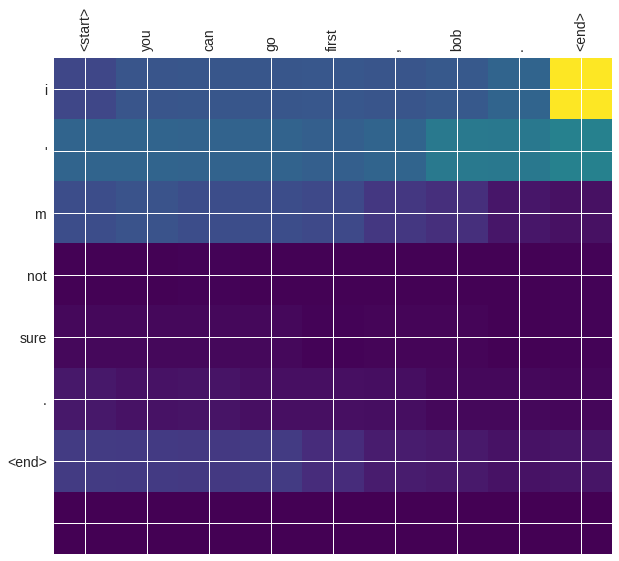

In [22]:
print(datetime.datetime.now())
translate('you can go first , bob .', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

2018-11-07 10:10:11.224731
Input: <start> how are you dave ? <end>
Predicted translation: i ' m not a good tittie . <end> 


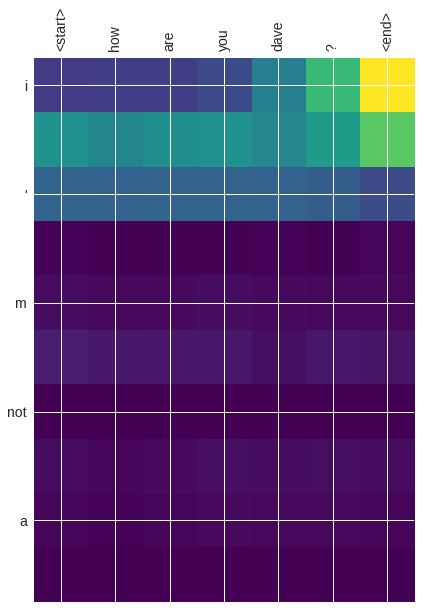

In [23]:
print(datetime.datetime.now())
translate('how are you Dave?', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

2018-11-07 10:10:12.696649
Input: <start> some times people say mean things . <end>
Predicted translation: i ' m not a good housekeeping and the landlady and i ' m not going to be a good housekeeping and the landlady and i ' m not going to be a good housekeeping and the landlady and i ' m not going to be a good housekeeping and the landlady and i ' m not going to 


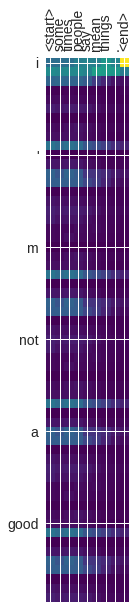

In [24]:
print(datetime.datetime.now())
translate('Some times people say mean things.', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

2018-11-07 10:10:15.211729
Input: <start> the pilot says it is does not have the markings of a commercial jet . <end>
Predicted translation: he ' s a good housekeeping seal . <end> 


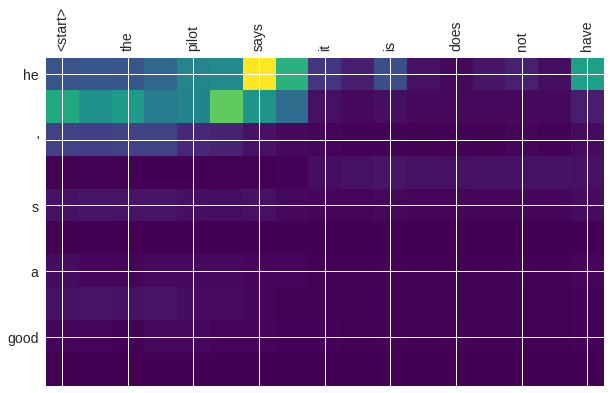

In [25]:
print(datetime.datetime.now())
translate('the pilot says it is does not have the markings of a commercial jet .', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)